In [1]:
from datetime import datetime
import scipy.io as sio
import re
import os
import h5py
import csv
import tensorflow as tf
import time
import logging
import zipfile
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('default')
import numpy as np
from moviepy.editor import *
import smtplib

import caiman as cm
from caiman.source_extraction import cnmf
from caiman.utils.visualization import inspect_correlation_pnr
from caiman.motion_correction import MotionCorrect
from caiman.source_extraction.cnmf import params as params
import peakutils

"""# Prepare data"""

import os
import subprocess

In [2]:
#%% restart cluster to clean up memory
#if 'dview' in locals():
#    cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=2, single_thread=False, ignore_preexisting=False)
n_processes

2

## Load Motion Corrected data

In [7]:
result_data_dir = '/home/prez/neurodata/cheeseboard-down/down_2/2020-10/habituation/2020_10_08/caiman/N-BL/'

load_mmap = True
if not load_mmap:
    mc_fpath = result_data_dir + '/mc.avi'
    fname_new = cm.save_memmap([mc_fpath], base_name='memmap_',
                                order='C', border_to_0=0, dview=dview)
else:
    fname_new = '/home/prez/neurodata/cheeseboard-down/down_2/2020-10/habituation/2020_10_08/trial/N-BL/Session1/14_16_09/Miniscope/memmap_0000_d1_178_d2_202_d3_1_order_C_frames_1000_.mmap'

# load memory mappable file
Yr, dims, T = cm.load_memmap(fname_new)
images = Yr.T.reshape((T,) + dims, order='F')
images.shape

(1000, 178, 202)

Text(0.5, 1.0, 'PNR')

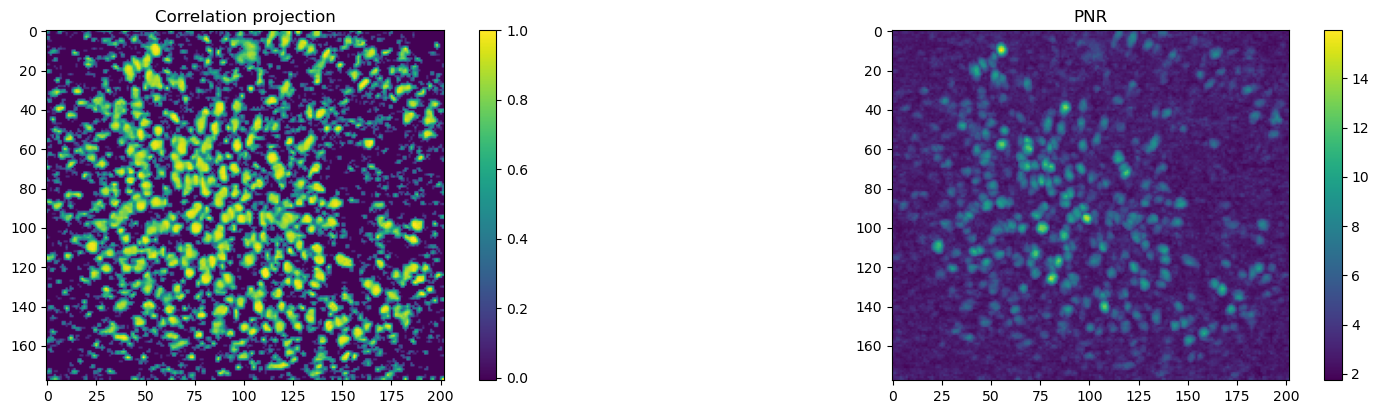

In [4]:
# Compute some summary images (correlation and peak to noise) while downsampling temporally 5x to speedup the process and avoid memory overflow
cn_filter, pnr = cm.summary_images.correlation_pnr(images[::5], gSig=3, swap_dim=False) # change swap dim if output looks weird, it is a problem with tiffile

#Plot the results of the correlation/PNR projection
plt.figure(figsize=(20,10))
plt.subplot(2, 2, 1); plt.imshow(cn_filter); plt.colorbar(); plt.title('Correlation projection')
plt.subplot(2, 2, 2); plt.imshow(pnr); plt.colorbar(); plt.title('PNR')
#plt.savefig(result_data_dir + '/' + 'pnr.svg', edgecolor='w', format='svg', transparent=True)

## Run CNMFE

In [19]:
frate = 20
opts_dict = {
  'fr': frate,
  'use_cuda' : False,
  'memory_fact': 0.6,
  'decay_time': 0.4,
  #'splits_rig': 1,  # for parallelization split the movies in num_splits chunks across time
  'method_init': 'corr_pnr',  # use this for 1 photon
  'K': None, # upper bound on number of components per patch, in general None
  'gSig': [3, 3], # gaussian width of a 2D gaussian kernel, which approximates a neuron
  'gSiz': [13, 13], # average diameter of a neuron, in general 4*gSig+1
  'merge_thr': 0.7, # merging threshold, max correlation allowed
  'p': 1, # order of the autoregressive system
  'tsub': 1, # downsampling factor in time for initialization
  'ssub': 1, # downsampling factor in space for initialization
  'rf': 40, # half-size of the patches in pixels
  'stride': 20, # overlap between the patches in pixels (keep it at least large as gSiz)
  'only_init': True,    # set it to True to run CNMF-E
  'nb': 0, # number of background components (rank) if positive,
#             else exact ring model with following settings
#             gnb= 0: Return background as b and W
#             gnb=-1: Return full rank background B
#             gnb<-1: Don't return background

  'nb_patch': 0,# number of background components (rank) per patch if gnb>0
  'method_deconvolution': 'oasis',       # could use 'cvxpy' alternatively
  'low_rank_background': None, # leaves background of each patch intact True performs global low-rank approximation if gnb>0

  'update_background_components': True,  # sometimes setting to False improve the results
  'min_corr': 0.8, # min peak value from correlation image
  'min_pnr': 8, # min peak to noise ration from PNR image
  'normalize_init': False,               # just leave as is
  'center_psf': True,                    # leave as is for 1 photon
  'ssub_B': 2, # downsampling factor for background
  'ring_size_factor': 1.4, # radius of ring is gSiz*ring_size_factor
  'del_duplicates': True,                # whether to remove duplicates from initialization
  'border_pix': 2 # number of pixels to not consider in the borders)
}
opts = params.CNMFParams(params_dict=opts_dict)

In [21]:
dims

(178, 202)

In [20]:
start = time.time()
# Perform CNMF
cnm = cnmf.CNMF(n_processes=n_processes, dview=dview, Ain=None, params=opts)
cnm.fit(images[:99,:,:])

end = time.time()
print(end - start)

TypeError: 'numpy.float64' object cannot be interpreted as an integer

## Component Evaluation
The components are evaluated in three ways:
- the shape of each component must be correlated with the data
- a minimum peak SNR is required over the length of a transient
- each shape passes a CNN based classifier

In [ ]:
#%% COMPONENT EVALUATION


min_SNR = 3            # adaptive way to set threshold on the transient size
r_values_min = 0.8    # threshold on space consistency (if you lower more components
#                        will be accepted, potentially with worst quality)
cnm.params.set('quality', {'min_SNR': min_SNR,
                           'rval_thr': r_values_min,
                           'use_cnn': False})
cnm.estimates.evaluate_components(images, cnm.params, dview=dview)

print(' ***** ')
print('Number of total components: ', len(cnm.estimates.C))
print('Number of accepted components: ', len(cnm.estimates.idx_components))

## Plot results

In [ ]:
neuronsToPlot = 20

DeconvTraces = cnm.estimates.S
RawTraces = cnm.estimates.C
SFP = cnm.estimates.A
SFP_dims = list(dims)
SFP_dims.append(SFP.shape[1])
print('Spatial foootprints dimensions (height x width x neurons): ' + str(SFP_dims))

numNeurons = SFP_dims[2]

SFP = np.reshape(SFP.toarray(), SFP_dims, order='F')

maxRawTraces = np.amax(RawTraces)

plt.figure(figsize=(30,15))
#plt.subplot(341);
#plt.subplot(345); plt.plot(mc.shifts_rig); plt.title('Motion corrected shifts')
plt.subplot(3,4,9);
plt.subplot(3,4,2); plt.imshow(cn_filter); plt.colorbar(); plt.title('Correlation projection')
plt.subplot(3,4,6); plt.imshow(pnr); plt.colorbar(); plt.title('PNR')
plt.subplot(3,4,10); plt.imshow(np.amax(SFP,axis=2)); plt.colorbar(); plt.title('Spatial footprints')

plt.subplot(2,2,2); plt.figure; plt.title('Example traces (first 50 cells)')
plot_gain = 10 # To change the value gain of traces
if numNeurons >= neuronsToPlot:
  for i in range(neuronsToPlot):
    if i == 0:
      plt.plot(RawTraces[i,:],'k')
    else:
      trace = RawTraces[i,:] + maxRawTraces*i/plot_gain
      plt.plot(trace,'k')
else:
  for i in range(numNeurons):
    if i == 0:
      plt.plot(RawTraces[i,:],'k')
    else:
      trace = RawTraces[i,:] + maxRawTraces*i/plot_gain
      plt.plot(trace,'k')

plt.subplot(2,2,4); plt.figure; plt.title('Deconvolved traces (first 50 cells)')
plot_gain = 20 # To change the value gain of traces
if numNeurons >= neuronsToPlot:
  for i in range(neuronsToPlot):
    if i == 0:
      plt.plot(DeconvTraces[i,:],'k')
    else:
      trace = DeconvTraces[i,:] + maxRawTraces*i/plot_gain
      plt.plot(trace,'k')
else:
  for i in range(numNeurons):
    if i == 0:
      plt.plot(DeconvTraces[i,:],'k')
    else:
      trace = DeconvTraces[i,:] + maxRawTraces*i/plot_gain
      plt.plot(trace,'k')

#plt.savefig(result_data_dir + '/' + 'summary_figure.svg', edgecolor='w', format='svg', transparent=True)

In [ ]:
cnm.estimates.plot_contours_nb(img=Cn, idx=cnm2.estimates.idx_components)

In [ ]:
cnm.estimates.nb_view_components(img=Cn, idx=cnm2.estimates.idx_components)

In [22]:
# Stop the cluster
cm.stop_server(dview=dview)

AttributeError: 'NoneType' object has no attribute 'terminate'